# Awkward Arrays for Simulated Data

## Loading the Data

* Uproot can open not just local ROOT files, but it can also open remote files. We will be working with a file which is hosted by CERN's Open Data Portal.
* Note: If you are unable to access the remote file, uncomment the next cell and run it to download an alternative, smaller file.

Run the following command to copy another, smaller file in your working directory

``` bash
wget https://cernbox.cern.ch/remote.php/dav/public-files/d0FqsjN68SsBlul/uproot-tutorial-file.root
````

In [36]:
# Uncomment the following line and run to download the data file directly from the notebook
# !wget wget https://cernbox.cern.ch/remote.php/dav/public-files/d0FqsjN68SsBlul/uproot-tutorial-file.root

In [37]:
import uproot

file = uproot.open(
    "./uproot-tutorial-file.root"
)
file.classnames()

{'Events;1': 'TTree'}

The `uproot.open` function provides a handle to the ROOT file, but does not actually read any data into memory at this stage. Instead, it allows you to explore the file structure and access its contents on demand. This approach is efficient because it avoids loading large datasets until you specifically request them. For example, after opening the file, you can inspect the available objects (such as TTrees or histograms) and only read the branches or entries you need for your analysis. This lazy-loading behavior is especially useful when working with large high-energy physics datasets.

Now that we have a hande on the ROOT file we want to use, let's use that to now get a handle on the "Events" TTree.

In [38]:
tree = file["Events"]
tree

<TTree 'Events' (6 branches) at 0x000131f9d6d0>

Keep in mind that we still have not read any data. Before doing that, its important that we see what is inside the TTree using the `show` method we learned about in the last chapter.

In [39]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge          | int32_t[]                | AsJagged(AsDtype('>i4'))


We can see that it contains some physics observables. Getting some understanding of this data is important for the next steps we will be taking, so lets go through each observable:
  
  - `nMuon`: The number of muons in the event
  - `Muon_pt`: The $p_T$ of each of those muons
  - `Muon_eta`: The $\eta$ coordinate of each muon
  - `Muon_phi`: The $\phi$ coordinate of each muon
  - `Muon_mass`: The mass of each muon
  - `Muon_charge`: The charge of each muon

Here, `Muon_phi` and `Muon_eta` refers to the corresponding spacial coordinates used in the CMS coordinate system. The following figure illustrates these coordinates in the CMS experiemnt.

```{figure} ./assets/axis3D_CMS.png
---
height: 350px
name: CMSaxis
---
Coordinate system in CMS
```

With this in mind, lets go ahead and finally load some data. We can do this by specifying the TBranch we want through the dict-like interphase of `tree` and then using the `array` or `arrays` method that are provided. For now, however, lets only load some of the data.

In [40]:
# Only loading 100 events
tree["nMuon"].array(entry_start=0, entry_stop=100)

<Array [2, 2, 1, 4, 4, 3, 2, 2, ..., 2, 3, 4, 1, 2, 0, 2] type='100 * uint32'>

In [41]:
# Alternative: (Not neccessarily the preferred way if you're only interested in loading a single branch)
tree["nMuon"].arrays()

<Array [{nMuon: 2}, {...}, ..., {nMuon: 3}] type='100000 * {nMuon: uint32}'>

If we wanted to load more than a single branch, we could use the `arrays` method.

In [42]:
event_data = tree.arrays(["nMuon", "Muon_pt"], entry_stop=100)

In [43]:
print(type(event_data))
print(type(event_data[0]))

<class 'awkward.highlevel.Array'>
<class 'awkward.highlevel.Record'>


Note that what we obtain is rather special and it sort of looks like dictionaries inside an array. The object we are working with is actually an Awkward array, the Awkward library's equivalent of a NumPy array, which contains Awkard records, the equivalent to a dictionary. This might seem trivial, but this data structure is actually quite powerful. For instance, suppose you want to only get the `Muon_pt` of this loaded data. To do that, you pass a key value in between brakets to the Awkward array, and you will get in return an Awkward array containing the value for that key for every record/event in that array.

In [44]:
event_data["Muon_pt"]

<Array [[10.8, 15.7], [...], ..., [], [24.1, 13.1]] type='100 * var * float32'>

Note that we are now dealing with a jagged array. We can work with it similarly to how we work with NumPy arrays.*

In [45]:
event_data["Muon_pt"][0:10]

<Array [[10.8, 15.7], [10.5, ...], ..., [11.5, 3.47]] type='10 * var * float32'>

In [46]:
# Note: Only possible if there is at least one Muon in each event. Try with `event_data["nMuon"][:, 0]` to see what happens if we include events with no Muons.
event_data["Muon_pt"][0:10, 0] 

<Array [10.8, 10.5, 3.28, 11.4, ..., 11.3, 10.2, 11.5] type='10 * float32'>

**Exercise**: Print out the $p_T$ and charge of the muons from events 100 to 115. There are two main ways to do this. Can you figure out what they are? Which method is faster? (Hint: Use the `%%timeit` magic)

Before moving on to exploring the data, its important to keep something in mind: because the data we typically deal with is quite large, unless neccesary, its good practice to specify the particular TBranches you want instead of doing something like `tree.arrays()` as this will load in everything, including things you might not be interested in. We already saw one way of loading specific branches, namely:

In [47]:
tree.arrays(["nMuon", "Muon_pt"], entry_stop=100)

<Array [{nMuon: 2, Muon_pt: [...]}, ..., {...}] type='100 * {nMuon: uint32,...'>

Another way would be:

In [48]:
tree.arrays(filter_name=["nMuon", "Muon_pt"], entry_stop=100)

<Array [{nMuon: 2, Muon_pt: [...]}, ..., {...}] type='100 * {nMuon: uint32,...'>

Note that we can also use wildcards in the TBranch filter.

In [49]:
tree.arrays(filter_name="Muon_*", entry_stop=100)

<Array [{Muon_pt: [...], ...}, ..., {...}] type='100 * {Muon_pt: var * floa...'>

If your TTree has a lot of branches, and `show` is impractical, you can also use `tree.keys`, which also accepts `filter_name` with wildcards. Then you can also verify the data type contained in each column by doing `tree.typenames()`

In [50]:
# Note: No filtering. But that's okay, because we're not reading data here.
tree.keys()

['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge']

In [51]:
tree.typenames()

{'nMuon': 'uint32_t',
 'Muon_pt': 'float[]',
 'Muon_eta': 'float[]',
 'Muon_phi': 'float[]',
 'Muon_mass': 'float[]',
 'Muon_charge': 'int32_t[]'}

Just like the `arrays` method, methods accept a `filter_name` argument.

In [52]:
tree.keys(filter_name="Muon_*")

['Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge']

In [53]:
tree.typenames()

{'nMuon': 'uint32_t',
 'Muon_pt': 'float[]',
 'Muon_eta': 'float[]',
 'Muon_phi': 'float[]',
 'Muon_mass': 'float[]',
 'Muon_charge': 'int32_t[]'}

As a last point, for pedagogical purposes, we can also load the data in the form of a Pandas DataFrame, which will highlight the tabular nature of the data. Note, however, that doing this is not usual, and it is usually preferrable to use Awkward Arrays to handle your data.

In [54]:
import pandas as pd

tree.arrays(library="pd", entry_stop=10)

,nMuon,Muon_pt,Muon_eta,Muon_phi,Muon_mass,Muon_charge
0,2,"[10.763696670532227, 15.736522674560547]","[1.0668272972106934, -0.563786506652832]","[-0.03427272289991379, 2.5426154136657715]","[0.10565836727619171, 0.10565836727619171]","[-1, -1]"
1,2,"[10.538490295410156, 16.327096939086914]","[-0.42778006196022034, 0.34922507405281067]","[-0.2747921049594879, 2.539781332015991]","[0.10565836727619171, 0.10565836727619171]","[1, -1]"
2,1,[3.2753264904022217],[2.210855484008789],[-1.2234135866165161],[0.10565836727619171],[1]
3,4,"[11.429154396057129, 17.634033203125, 9.624728...","[-1.5882395505905151, -1.7511844635009766, -1....","[-2.0773041248321533, 0.25135836005210876, -2....","[0.10565836727619171, 0.10565836727619171, 0.1...","[1, 1, 1, 1]"
4,4,"[3.2834417819976807, 3.64400577545166, 32.9112...","[-2.1724836826324463, -2.18253493309021, -1.12...","[-2.3700082302093506, -2.3051390647888184, -0....","[0.10565836727619171, 0.10565836727619171, 0.1...","[-1, -1, 1, 1]"
5,3,"[3.566528081893921, 4.572504043579102, 4.37186...","[-1.371932029724121, -0.703264594078064, -1.03...","[-2.9090449810028076, 2.4552080631256104, -3.0...","[0.10565836727619171, 0.10565836727619171, 0.1...","[-1, 1, -1]"
6,2,"[57.6067008972168, 53.04507827758789]","[-0.5320892930030823, -1.0041686296463013]","[-0.07179804146289825, 3.089515209197998]","[0.10565836727619171, 0.10565836727619171]","[-1, 1]"
7,2,"[11.31967544555664, 23.906352996826172]","[-0.7716585397720337, -0.700996994972229]","[-2.2452728748321533, -2.1809616088867188]","[0.10565836727619171, 0.10565836727619171]","[1, -1]"
8,2,"[10.19356918334961, 14.204060554504395]","[0.4418068528175354, 0.7021172642707825]","[0.6778520345687866, -2.0344009399414062]","[0.10565836727619171, 0.10565836727619171]","[-1, 1]"
9,2,"[11.470704078674316, 3.4690065383911133]","[2.3417420387268066, 2.3523731231689453]","[3.1309704780578613, 3.0211737155914307]","[0.10565836727619171, 0.10565836727619171]","[-1, 1]"


## Reconstructing the mass

Now that we know what the branches look like and what is the data type each one contains, let's explore the data and try to do something useful with it. Note that the data contains physical observables for muons in each collision event. What would happen if we add the mass of two muons in an event? Let's find out! First, lets load a sub-set of the events contained in the sample.

In [55]:
# Loading in some data from all branches
muons = tree.arrays(entry_stop=1500)
muons

<Array [{nMuon: 2, Muon_pt: [...], ...}, ...] type='1500 * {nMuon: uint32, ...'>

Just for simplicity, let's ensure there are two muons in each event. Later on, we will do something more sophisticated. To do this, we can create a filer or mask similarly to how we created masks for NumPy arrays. What we want is for mask to be `True` when an event has exactly 2 events, and `False` otherwise. Fortunately, we have the field `nMuon` which immediately provides us with the information we need to construct this mask as follows.

In [56]:
# If an event has 2 muons, its corresponding element in the mask is True. False otherwise.
mask = muons["nMuon"] == 2
mask

<Array [True, True, False, False, ..., True, True, True] type='1500 * bool'>

We can now apply this mask the exact same way we applied masks with NumPy array!

In [57]:
# Only keeping di-muon events
dimuons = muons[mask]
dimuons

<Array [{nMuon: 2, Muon_pt: [...], ...}, ...] type='812 * {nMuon: uint32, M...'>

We can make sure that the resulting filtered array only has events with two muons by using the function `ak.all` provided by Awkward. This function takes in an array of booleans (although not neccesary that the elements are booleans), and tells you whether *all* elements are `True`. This would be equivalent to applying the `AND` boolean operator over the whole array.

In [58]:
import awkward as ak
ak.all(dimuons["nMuon"] == 2)

np.True_

Let's now get the observables into their own variables for future convenience.

In [59]:
# Getting the eta, pt and phi of each of the muons in the dimuon events
pt0 = dimuons["Muon_pt"][:,0]
pt1 = dimuons["Muon_pt"][:,1]
eta0 = dimuons["Muon_eta"][:,0]
eta1 = dimuons["Muon_eta"][:,1]
phi0 = dimuons["Muon_phi"][:,0]
phi1 = dimuons["Muon_phi"][:,1]

Let's assume the two muons came from the decay of a particle $A$. We make use of the fact that the square of the total 4-momentum of the system is an invariant quantity to establish that

```{math}
(p_A)^\nu (p_A)_\nu = (p_1+p_2)^\sigma (p_1+p_2)_\sigma
```

where the left side comes from the initial state of the system, in an inertial reference frame where the $A$ is stationary, and the right side corresponds to the final state of the system (i.e., when we have two muons) in the lab reference frame. This reduces to:

```{math}
m_{A} = \sqrt{(E_1 + E_2)^2 - \|\textbf{p}_1 + \textbf{p}_2 \| ^2} = \sqrt{(E_1+E_2)^2-((p_{1_x}+p_{2_x})^2+(p_{1_y}+p_{2_y})^2+(p_{1_z}+p_{2_z})^2)}|
```

which, under the assumption that $E \gg m$ and changing the coordinates this equation is written in, this reduces to:

```{math}
m_{A} = \sqrt{
    2p_{T,0} p_{T,1} * \left(\cosh(\eta_0 - \eta_1) - \cos(\phi_0- \phi_1)\right)
}
```

We can then use this equation to compute the mass of the hypothetical particle these pairs of muons came from. This is easy to do with Awkward arrays!

In [60]:
import numpy as np
mass = np.sqrt(2 * pt0 * pt1 * (np.cosh(eta0 - eta1) - np.cos(phi0 - phi1)))
mass

<Array [34.4, 27.9, 114, 1.57, ..., 3.1, 2.51, 91.1, 29] type='812 * float32'>

The raw data for the reconstructed mass is difficult to interpret without an effective way to visualize it. One of the most common tools in a high energy physicist's toolkit is the histogram. Histograms display the frequency of data values within specified ranges (bins). This allows us to see the distribution and identify features such as peaks or tails in the data and will make it much easier for us to understand the underlying physics represented by the reconstructed mass values.

To make the histogram, we will use the Hist library, one of the many tools offered by Scikit-HEP. This library offers a user-friendly API for the Boost-histogram Python library which offers a highly efficient and flexible histogramming framework. You can find detailed information about this libarry in the documentation, which you can access through this link: [link](https://hist.readthedocs.io/en/latest/user-guide/axes.html).

In addition, to easily make our plot look pretty and to follow the conventions used in HEP publications, we will use the `mplhep` library, also from Scikit-HEP. This library provides convenient plotting styles and functions for HEP data, making it straightforward to produce publication-quality figures that match the look and feel of experiments like CMS or ATLAS. By combining `Hist` for efficient histogramming and `mplhep` for styling, we can quickly generate insightful and professional plots of our reconstructed mass distributions. 

Under the hood, Hist actually uses Matplotlib to render plots, which means we can take advantage of all the customization and flexibility that Matplotlib offers. Thus, we will import Matplotlib as well to get full access to the plotting tools that this library has to offer.

In [61]:
import hist
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("CMS")

Let's create a histogram object (i.e., `hist.Hist`) with a single axis. We do this as follows.

In [84]:
masshist = hist.Hist(
    hist.axis.Regular(120, 0, 200, label="Mass [GeV]", name="mass"),
)

If we were to plot the histogram right now, we would see that it would be empty, as we have not put any data into it.

In [85]:
masshist

Hist(Regular(120, 0, 200, name='mass', label='Mass [GeV]'), storage=Double())

To add our data, we use the `fill` method and pass the array of the reconstructed masses we made. This method immediately returns the histogram, from which we can get a glimpse of how it looks like.

In [86]:
masshist.fill(mass)

Hist(Regular(120, 0, 200, name='mass', label='Mass [GeV]'), storage=Double()) # Sum: 48922.0 (48976.0 with flow)

To make a proper plot of this histogram, we will use Matplotlib to create a figure with an axis, and then use the `plot1d` method of the `hist.Hist` object to plot the histogram we have created on those axis.

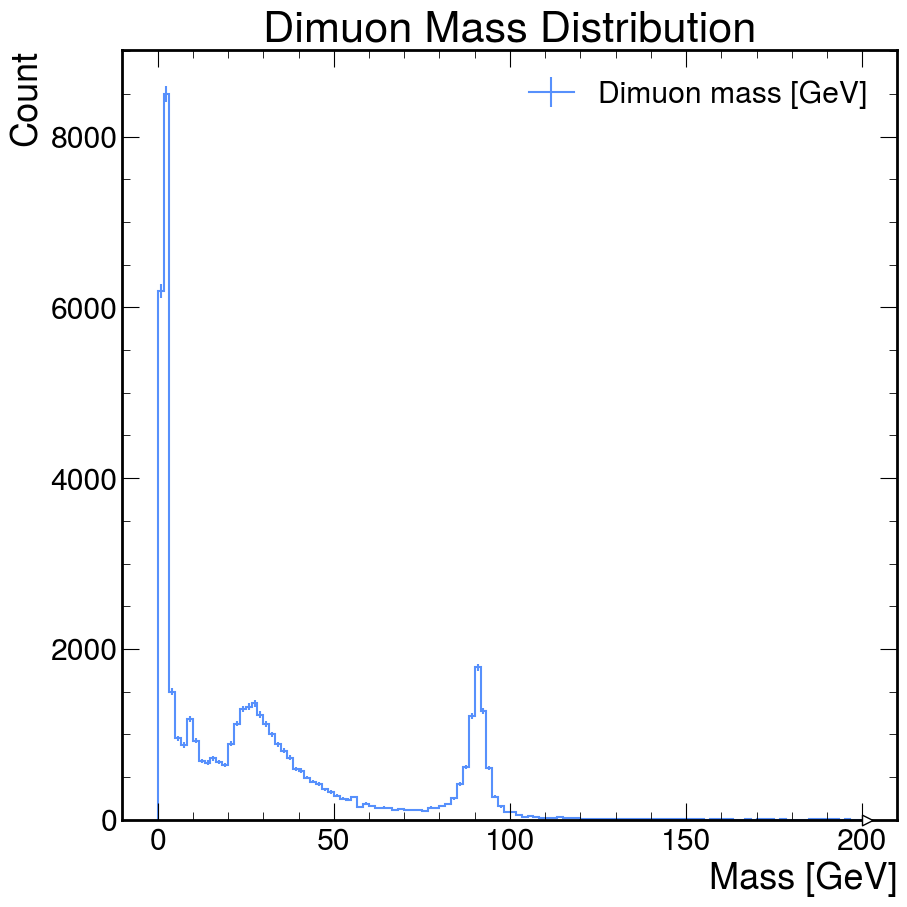

In [ ]:
# Using Hist + Matplotlib
fig, ax = plt.subplots()

masshist.plot1d(
    ax=ax, 
    label="Dimuon mass [GeV]", 
)

# Adding label for the y-axis
ax.set_ylabel("Count")
# Adding axis title
ax.set_title("Dimuon Mass Distribution")
# Adding legend
ax.legend()

# Show the plot
plt.show()

From this plot, we see multiple peaks. Notice, however that there is a peak very near $90 \text{ GeV}$. This corresponds to the mass of the Z boson, and it means that we have been able to reconstruct its mass even though our approach was quite rudimentary. We can confirm the exact value for the mass of the Z boson by using the particle Particle library which provides particle data from the Particle Data Group ([PDF website](https://pdg.lbl.gov/)). We will also use the `hepunits` library which provivdes units and constants for the HEP system of units.

In [112]:
import particle
from hepunits import GeV

# Getting the mass of the Z boson
z_mass = particle.Particle.from_name("Z0")
print("Z boson mass in GeV:", z_mass.mass / GeV)

Z boson mass in GeV: 91.188


We can also make the previous histogram, but now lets add a vertical line on the Z mass for emphasis.

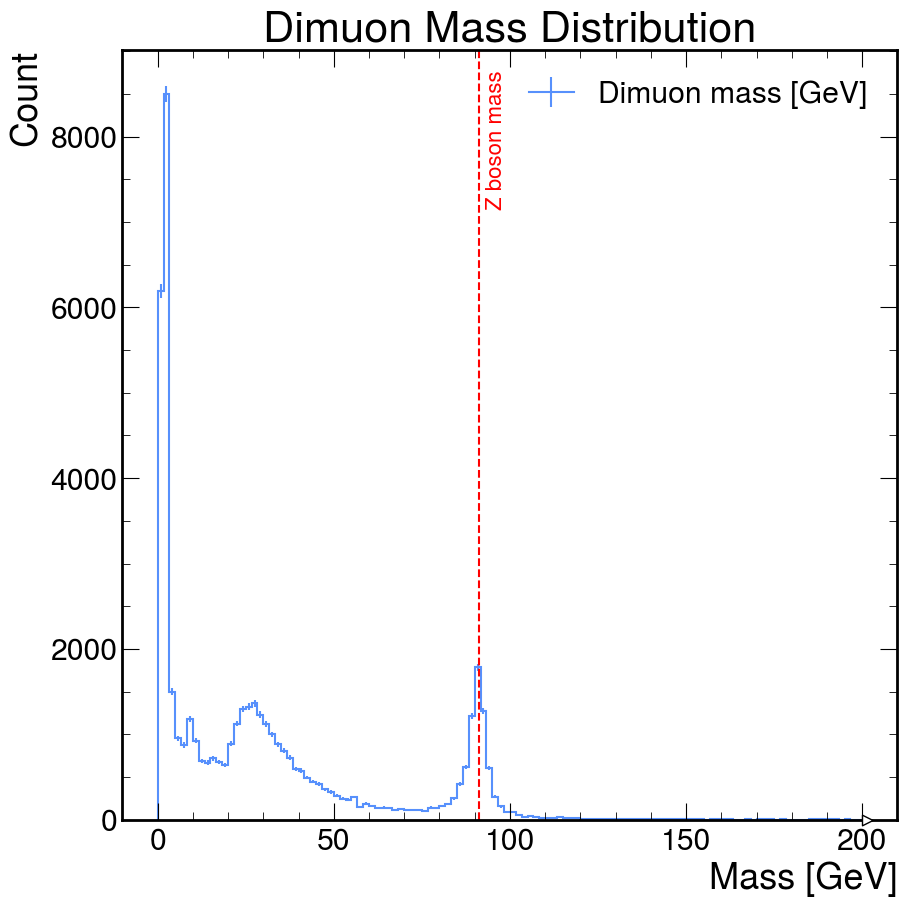

In [130]:
# Plotting a a vertical line at the Z boson mass
# Using Hist + Matplotlib
fig, ax = plt.subplots()

masshist.plot1d(
    ax=ax, 
    label="Dimuon mass [GeV]", 
)

ax.set_ylabel("Count")
ax.set_title("Dimuon Mass Distribution")
ax.legend()
ax.axvline(z_mass.mass / GeV, color="red", linestyle="--", label="Z boson mass")
ax.text(z_mass.mass / GeV + 2, 7200, "Z boson mass", color="red", rotation=90, fontsize=16)

plt.show()

While we have been successful at reconstructing the mass of the Z boson to some extent, our approach is quite basic. First, we excluded many events that have more than two muons, even though some of these events might contain two or more muons that originated from a Z boson. Additionally, we did not ensure that quantities such as charge were conserved. We simply added the masses of the muons without verifying these important details. We will address these considerations in the next chapter. For now, lets review once again the code we have developed so far for reconstructing the masses.

<>:27: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\m'
/var/folders/t8/8pnmh4rj2lbbd7gfq8tf09180000gn/T/ipykernel_23517/3237670559.py:27: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel("$m_{\mu\mu}$")


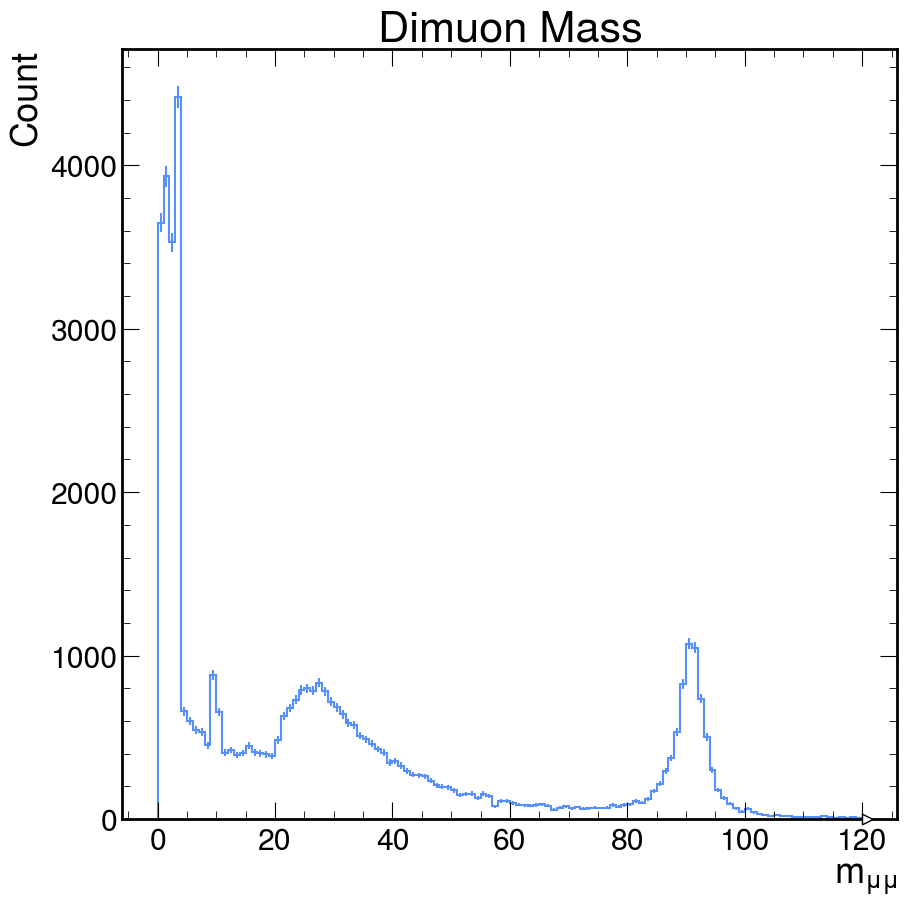

In [133]:
# Loading data
muons = tree.arrays(filter_name="/nMuon|Muon_(phi|eta|pt)/", entry_stop=100000)

# Applying a cut
dimuons_cut = muons["nMuon"] == 2
dimuons = muons[dimuons_cut]

# Getting the eta, pt and phi of each of the muons in the dimuon events
pt0 = dimuons["Muon_pt"][:,0]
pt1 = dimuons["Muon_pt"][:,1]
eta0 = dimuons["Muon_eta"][:,0]
eta1 = dimuons["Muon_eta"][:,1]
phi0 = dimuons["Muon_phi"][:,0]
phi1 = dimuons["Muon_phi"][:,1]

# Calculating the mass of the dimuon system
mass = np.sqrt(2 * pt0 * pt1 * (np.cosh(eta0 - eta1) - np.cos(phi0 - phi1)))

# Plotting the mass distribution using Hist + Matplotlib
fig, ax = plt.subplots()

masshist = hist.Hist(hist.axis.Regular(120, 0, 120, label="mass [GeV]"))
masshist.fill(mass)
masshist.plot1d(ax=ax)

ax.set_title("Dimuon Mass")
ax.set_xlabel("$m_{\mu\mu}$")
ax.set_ylabel("Count")

plt.show()

For the rest of this workshop, we will focus on the Z and Higgs boson. However, you might be wondering what those extra peaks are to the left of the Z peak. To emphasize these peaks, let's make the plot logarithmic.

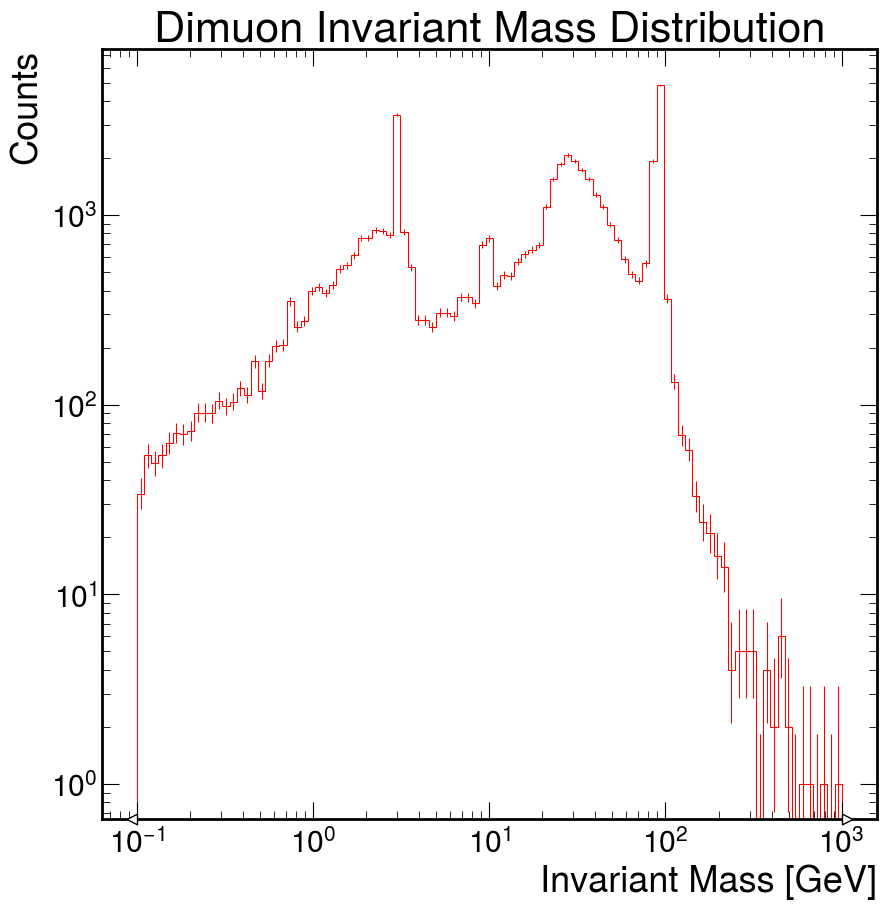

In [ ]:
fig, ax = plt.subplots()

# Note: Making a logarithmic hist axis (i.e. hist with variable binning)
hist_data = hist.Hist(
    hist.axis.Variable(np.logspace(np.log10(0.1), np.log10(1000), 100), name="mass", label="Invariant Mass [GeV]")
)
hist_data.fill(mass=mass)
hist_data.plot1d(ax=ax, histtype='step', color="red", linewidth=0.75)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Invariant Mass [GeV]")
ax.set_ylabel("Counts")
ax.set_title("Dimuon Invariant Mass Distribution")

plt.show()

Compare this to this cleaner dimuon mass spectrum with labels identifying what each peak corresponds to.

```{figure} ./assets/dimuonspectrumplt.png
---
height: 350px
name: Dimuon spectrum
---
Dimuon mass spectrum
```